In [112]:
import os
import io
import shutil
import subprocess
import gc
import xarray as xr
import numpy as np
import pygmt
import geopandas as gpd
import xarray as xr
import pandas as pd
from pygmt.params import Box

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

In [2]:
# Função simples de equalização de histograma (como grdhisteq)
def hist_eq(data):
    # achatamos, equalizamos e reescalamos
    data_flat = data.ravel()
    hist, bins = np.histogram(data_flat, bins=256, density=True)
    cdf = hist.cumsum()
    cdf = 255 * cdf / cdf[-1]
    data_eq = np.interp(data_flat, bins[:-1], cdf)
    return data_eq.reshape(data.shape)

In [ ]:
grid = pygmt.load_dataarray("/Users/joao_macedo/opt/ETOPO5.nc", engine="gmt", raster_kind="grid") #fiz um resample no grid para 5 minutos de arco
# grid = pygmt.grdsample(
#     grid=grid_initial,
#     spacing="1m"   # 5 minutos de arco (~9 km)
# )

gradient = pygmt.grdgradient(
    grid=grid,
    azimuth=90,   # -A90 → direção da iluminação (vinda do leste)
    normalize=0.5 # -N0.5 → normalização (realça contraste)
)

PSL: Warning: Font-color change not terminated [@;red;P-T or P-T-t data available]
PSL: Warning: Font-color change not terminated [@;purple;Lack of P-T orP-T-t data]
PSL: Warning: Font-color change not terminated [@;255.000000/0.000000/0.000000;P-T or P-T-t data available]
PSL: Warning: Font-color change not terminated [@;160.000000/32.000000/240.000000;Lack of P-T orP-T-t data]


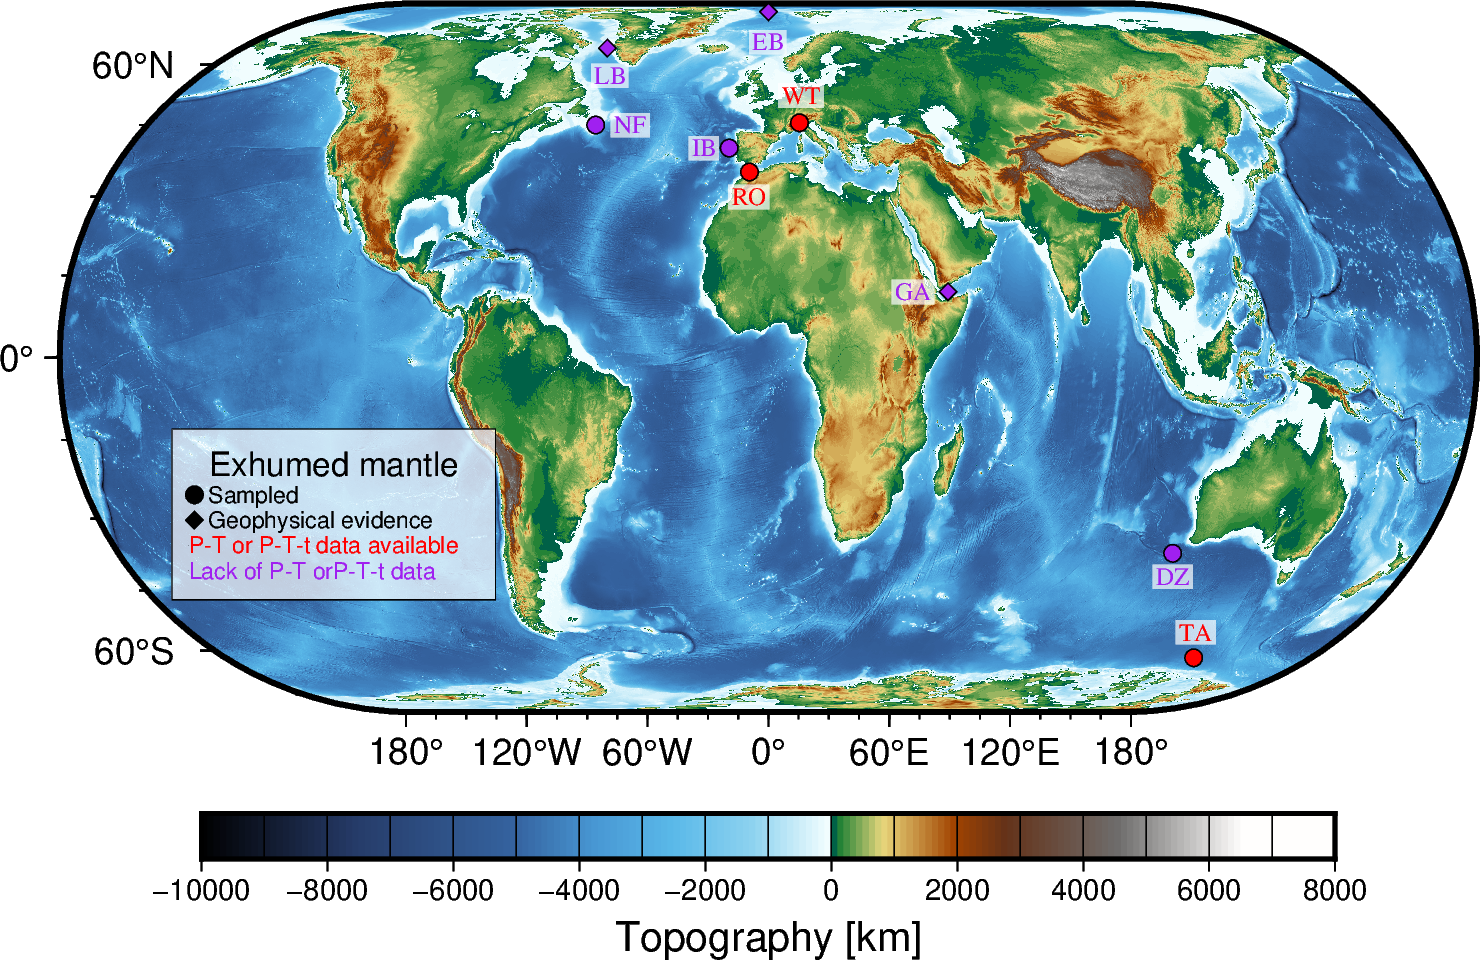

In [251]:
# Aplicar equalização ao gradiente
eq_data = hist_eq(gradient.data)

# Recriar DataArray compatível com GMT
smooth_int = xr.DataArray(eq_data, coords=gradient.coords, dims=gradient.dims)

factor = 0#1.0e-4  # ajuste conforme desejar
fileout = "intensity_output.nc"

result = smooth_int * factor

# Salvar em arquivo (opcional)
result.to_netcdf(fileout)

plt.close()
fig = pygmt.Figure()

# Criar paleta de cores
pygmt.makecpt(cmap="geo", series=[-10000, 8000, 100])

region = [-180, 180, -89, 89]
# region = [-180, 180, -89, 60]
# region = [-120, 120, -89, 89]
# projection = 'Cyl_stere/-30/-20/12c'
# projection = 'W12c'
projection =  'Kf12c'

# projection = 'N12c'
# projection = 'G0/20/12c'

# fig.plot(data, style='c0.1c')

fig.grdimage(grid=grid,
             shading=result,
             region=region,
             projection=projection,
             frame=True#"a30g"
             )
fig.colorbar(frame=["a2000g", "x+lTopography [km]"])

#Plotting coordinates of exhumed mantle locations
#Iberia-Newfoundland
marker_sample = 'c0.15c'
marker_geophysics = 'd0.15c'

color_this_work = 'red'
color_other_works = 'purple'
exhumed_mantle_coords = pd.DataFrame({
    'Latitude': [40.0,
                 45.0,
                 65.0,
                 80.0,
                 12.0,
                 -37.0,
                 45.5,
                 -62.0,
                 35.0,
                 ],

    'Longitude': [-11.0,
                  -50.0,
                  -55.0,
                  0.0,
                  46.0,
                  112.0,
                  9.0,
                  141.0,
                  -5.2,
                  ],

    'Location': ['Iberia',
              'Newfoundland',
              'Labrador-Greenland',
              'Eurasia Basin',
              'Gulf of Aden',
              'Diamantina Zone',
              'Western Tethys',
              'Terre Adélie',
              'Ronda'
              ],

    'color': [color_other_works,
              color_other_works,
              color_other_works,
              color_other_works,
              color_other_works,
              color_other_works,
              color_this_work,
              color_this_work,
              color_this_work,
              ],

    'style': [marker_sample,
              marker_sample,
              marker_geophysics,
              marker_geophysics,
              marker_geophysics,
              marker_sample,
              marker_sample,
              marker_sample,
              marker_sample,
            ]
})

for lat, lon, marker, colorfill in zip(exhumed_mantle_coords['Latitude'],
                              exhumed_mantle_coords['Longitude'],
                              exhumed_mantle_coords['style'],
                              exhumed_mantle_coords['color']):
    fig.plot(
        x=lon,
        y=lat,
        style=marker,
        fill=colorfill,
        pen='black'
    )

# legend_text = io.StringIO("""
# H 12 Helvetica Exhumed Mantle
# S 0.4c c 0.3c black 0.25p 0.25i Collected samples
# S 0.4c d 0.3c black 0.25p 0.25i Geophysics
# L 9p,Helvetica L Used in this work
# L 9p,Helvetica L Other works
# """)
marker_offset = 0.05
legend_text = io.StringIO(f"""
H 8 Helvetica Exhumed mantle
S {marker_offset}c c 0.15c black 0.25p {1.3*marker_offset}i Sampled
S {marker_offset}c d 0.15c black 0.25p {1.3*marker_offset}i Geophysical evidence
S 0.0c c 0.0c black 0.25p 0.0i @;{color_this_work};P-T or P-T-t data available
S 0.0c c 0.0c black 0.25p 0.0i @;{color_other_works};Lack of P-T orP-T-t data
""")
fsize = 5.5
with pygmt.config(FONT_ANNOT_PRIMARY=f"{fsize}p"):
    fig.legend(
        spec=legend_text,
        position="JBL+jBL+o0.95c",
        box=Box(pen="0.2p,black", fill="white@30")
        )


# Adiciona o texto manual
color_fill = 'white@30'
fontsize = '6p'
fontstyle = 'Times-Roman'
fig.text(x=-18,  y=40,  text="IB", font=f"{fontsize},{fontstyle},{color_other_works}", fill=color_fill) #Iberia
fig.text(x=-40,  y=45,  text="NF", font=f"{fontsize},{fontstyle},{color_other_works}", fill=color_fill) #Newfoundland
fig.text(x=-50,  y=57,  text="LB", font=f"{fontsize},{fontstyle},{color_other_works}", fill=color_fill) #Labrador
fig.text(x=0,    y=67,  text="EB", font=f"{fontsize},{fontstyle},{color_other_works}", fill=color_fill) #Eurasia Basin
fig.text(x=37,   y=12,  text='GA', font=f"{fontsize},{fontstyle},{color_other_works}", fill=color_fill) #Gulf of Aden
fig.text(x=115,  y=-42, text='DZ', font=f"{fontsize},{fontstyle},{color_other_works}", fill=color_fill) #Diamantina Zone
fig.text(x=10,   y=52,  text='WT', font=f"{fontsize},{fontstyle},{color_this_work}", fill=color_fill) #Western Tethys
fig.text(x=133,  y=-55, text='TA', font=f"{fontsize},{fontstyle},{color_this_work}", fill=color_fill) #Terre Adelie
fig.text(x=-5.2, y=30,  text='RO', font=f"{fontsize},{fontstyle},{color_this_work}", fill=color_fill) #


fig.show()
figname = "Exhumed_mantle_locations.png"
fig.savefig(f"figures/{figname}", dpi=400)